## Imports

In [30]:
pip3 install python-dotenv

SyntaxError: invalid syntax (Temp/ipykernel_31348/3614495634.py, line 1)

In [1]:
#import required libraries
#pandas to make and manipulate dataframes
#numpy for the technical analysis
import pandas as pd
import numpy as np
import math
import yfinance as yf
import tradingview_ta as tv
from tradingview_ta import TA_Handler, Interval, Exchange
import warnings
import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib widget
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

import os
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import json
import warnings
warnings.filterwarnings('ignore')
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Input Stock

In [4]:
#With this code you can input any stock and the data for the stock will be pulled from the Yahoo Finance API using yf.Ticker
#The data is pulled for 3 years with a daily timeframe and put into a dataframe called df_stock
value = input("Enter Stock Symbol:")
period = input('enter period of data eg 1y or 2y:')
interval = input('enter candle interval eg 1d, 1wk, 1mo, 1h')
stock = yf.Ticker(value)
print(stock.info)
stock_df = stock.history(period=period, interval=interval)
stock_df.index.duplicated().sum()
df_stock = stock_df.loc[~stock_df.index.duplicated(keep='first')]
df_stock.dropna(inplace=True)

Enter Stock Symbol: spy
enter period of data eg 1y or 2y: 1y
enter candle interval eg 1d, 1wk, 1mo, 1h 1d


{'exchange': 'PCX', 'shortName': 'SPDR S&P 500', 'longName': 'SPDR S&P 500 ETF Trust', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EDT', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-14400000', 'quoteType': 'ETF', 'symbol': 'SPY', 'messageBoardId': 'finmb_6160262', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 727660800, 'annualReportExpenseRatio': None, 'totalAssets': 371019022336, 'bookValue': None, 'fundFamily': 'SPDR State Street Global Advisors', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.013300001, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 'threeYear

## Create Bollinger Bands and Keltner Channel


In [5]:
# parameter setup (default values in the original indicator)
#These are the constants to be used for the moving averages and future indicator additions
length = 20
mult = 2
length_KC = 21
mult_KC = 2

In [6]:
# calculate Bollinger Bands which are the measure of the standard deviation.  These bands are set at the 2 times standard deviation
# moving average
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg
# standard deviation
m_std = df_stock['Close'].rolling(window=length).std()
# upper Bollinger Bands
df_stock['upper_BB'] = m_avg + mult * m_std
# lower Bollinger Bands 
df_stock['lower_BB'] = m_avg - mult * m_std
df_stock['bol_percent_b'] = ((df_stock['Close'] - df_stock['lower_BB'])/(df_stock['upper_BB'] - df_stock['lower_BB']))*100

In [7]:
# calculate Keltner Channel which is a measure of the average true range.  In this case the channels are set to twice the average true range
# first we need to calculate True Range
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()
# upper Keltner Channel
df_stock['upper_KC'] = m_avg + range_ma * mult_KC
# lower Keltner Channel
df_stock['lower_KC'] = m_avg - range_ma * mult_KC

## Create Candlestick Chart

In [38]:
# Creating dataframe to graph in candle stick mode
ohcl = df_stock[['Open', 'High', 'Close', 'Low', 'Volume']]
display(ohcl.head())
display(ohcl.tail())


,Open,High,Close,Low,Volume
Date,,,,,
2021-05-19,401.634701,405.711033,405.523499,400.065327,106467100
2021-05-20,406.451298,411.218580,409.886108,406.323012,78022200
2021-05-21,411.455431,412.768173,409.550507,409.066881,76578700
2021-05-24,411.919338,414.860643,413.725586,411.662706,51376700
2021-05-25,414.870498,415.245567,412.807648,412.195705,57451400


,Open,High,Close,Low,Volume
Date,,,,,
2022-05-12,389.369995,395.799988,392.339996,385.149994,125090800
2022-05-13,396.709991,403.179993,401.720001,395.609985,104029300
2022-05-16,399.980011,403.970001,400.089996,397.600006,78622400
2022-05-17,406.529999,408.570007,408.320007,402.579987,83029700
2022-05-18,403.500000,403.799988,391.859985,390.549988,117323500


In [9]:
#Calculating true range and adding to dataframe
df_stock['tr0'] = abs(df_stock["High"] - df_stock["Low"])
df_stock['tr1'] = abs(df_stock["High"] - df_stock["Close"].shift())
df_stock['tr2'] = abs(df_stock["Low"] - df_stock["Close"].shift())
df_stock['tr'] = df_stock[['tr0', 'tr1', 'tr2']].max(axis=1)
# moving average of the TR or average true range
range_ma = df_stock['tr'].ewm(span=length_KC).mean()

In [10]:
#Stacked Moving averages, exponentially weighted.  Focusing on Fibonacci numbers here with 8, 21, 34, 55 and 89 day moving averages
m_avg_08 = df_stock['Close'].ewm(span=8).mean()
m_avg_21 = df_stock['Close'].ewm(span=21).mean()
m_avg_34 = df_stock['Close'].ewm(span=34).mean()
m_avg_55 = df_stock['Close'].ewm(span=55).mean()
m_avg_89 = df_stock['Close'].ewm(span=89).mean()

df_stock['m_avg_08'] = m_avg_08
df_stock['m_avg_21'] = m_avg_21
df_stock['m_avg_34'] = m_avg_34
df_stock['m_avg_55'] = m_avg_55
df_stock['m_avg_89'] = m_avg_89

In [11]:
#Adding Moving Average Variable
#m_avg = df_stock['Close'].rolling(window=length).mean()
m_avg = df_stock['Close'].ewm(span=length).mean()
df_stock['Moving average'] = m_avg

In [12]:
#ADX Calculations
# Above 20 ADX means trending and below means sideways movement

plus_dm = df_stock["High"].diff()
minus_dm = df_stock["Low"].diff()
plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0

#plus_di and minus di show the direction of the trend, if plus_di > minus_di the trend is positive
#if minus_di > plus_di the trend is negative
df_stock['atr'] = df_stock['tr'].ewm(span=14).mean()
df_stock['plus_di'] = 100 * (plus_dm.ewm(alpha = 1/14).mean() / df_stock['atr'])
df_stock['minus_di'] = abs(100 * (minus_dm.ewm(alpha = 1/14).mean() / df_stock['atr']))
dx = (abs(df_stock['plus_di'] - df_stock['minus_di']) / abs(df_stock['plus_di'] + df_stock['minus_di'])) * 100
adx = ((dx.shift(1) * (14 - 1)) + dx) / 14
df_stock['adx'] = adx.ewm(alpha = 1/14).mean() #ADX>20 is trending ADX<20 not trending

In [13]:
#It uses the average directional index to determine the strength of the trend
#If ADX > 20 and the plus_di is above the minus_di the trend is positive
#If ADX > 20 and the plus_di is below the minus_di the trend is negative
#If ADX < 20 the trend is sideways

df_stock['ADX_trend'] = 20

def ADX_trend_flag(index):
    if (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] > df_stock['minus_di'][index]):
        print('positive trend')
    elif (df_stock['adx'][index] > df_stock['ADX_trend'][index]) and (df_stock['plus_di'][index] < df_stock['minus_di'][index]):
        print('negative trend')
    elif (df_stock['adx'][index] < df_stock['ADX_trend'][index]):
        print('neutral or sideways trend')

In [14]:
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Moving average,upper_BB,lower_BB,bol_percent_b,tr0,tr1,tr2,tr,upper_KC,lower_KC,m_avg_08,m_avg_21,m_avg_34,m_avg_55,m_avg_89,atr,plus_di,minus_di,adx,ADX_trend
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-19,401.634701,405.711033,400.065327,405.523499,106467100,0.0,0,405.523499,NaN,NaN,NaN,5.645707,NaN,NaN,5.645707,416.814912,394.232085,405.523499,405.523499,405.523499,405.523499,405.523499,5.645707,NaN,NaN,NaN,20
2021-05-20,406.451298,411.218580,406.323012,409.886108,78022200,0.0,0,407.813869,NaN,NaN,NaN,4.895568,5.695081,0.799513,5.695081,419.157008,396.470730,407.977467,407.808675,407.768959,407.744464,407.729313,5.672157,97.097919,0.000000,NaN,20
2021-05-21,411.455431,412.768173,409.066881,409.550507,76578700,0.0,0,408.451552,NaN,NaN,NaN,3.701293,2.882065,0.819228,3.701293,418.354186,398.548917,408.637654,408.445417,408.398073,408.368500,408.350070,4.919280,70.239434,0.000000,100.000000,20
2021-05-24,411.919338,414.860643,411.662706,413.725586,51376700,0.0,0,409.974084,NaN,NaN,NaN,3.197937,5.310136,2.112199,5.310136,420.082531,399.865637,410.420877,409.959725,409.849705,409.781691,409.739583,5.038854,58.881580,0.000000,100.000000,20
2021-05-25,414.870498,415.245567,412.195705,412.807648,57451400,0.0,0,410.659499,NaN,NaN,NaN,3.049862,1.519981,1.529880,3.049862,419.806590,401.512407,411.162300,410.642702,410.512876,410.431682,410.381081,4.519929,49.735793,0.000000,100.000000,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,389.369995,395.799988,385.149994,392.339996,125090800,0.0,0,416.382000,449.213367,383.550634,13.385618,10.649994,3.049988,7.600006,10.649994,438.426926,394.337075,403.594234,417.116201,424.003030,430.154147,435.482839,11.633984,12.112027,29.415998,22.842885,20
2022-05-13,396.709991,403.179993,395.609985,401.720001,104029300,0.0,0,414.985619,447.649855,382.321384,29.693971,7.570007,10.839996,3.269989,10.839996,436.997369,392.973869,403.177738,415.716546,422.729714,429.138528,434.729819,11.528119,15.922838,27.565693,24.111549,20
2022-05-16,399.980011,403.970001,397.600006,400.089996,78622400,0.0,0,413.566989,445.777755,381.356222,29.079989,6.369995,2.250000,4.119995,6.369995,434.735851,392.398126,402.491573,414.295951,421.436015,428.100967,433.957303,10.840369,16.244081,27.220657,24.293852,20


## Chart 

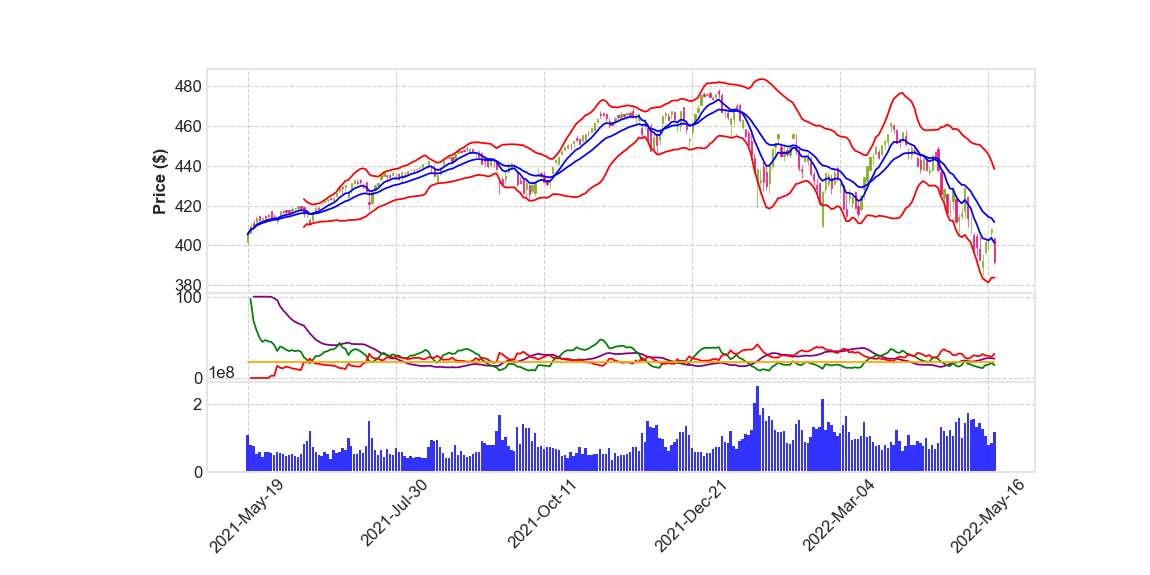

In [15]:
# Adding all the plots including ADX, 
apds = [mpf.make_addplot(df_stock[['upper_BB']], color = 'red'),
        mpf.make_addplot(df_stock[['lower_BB']], color = 'red'),
        mpf.make_addplot(df_stock['m_avg_08'], color = 'blue'),
        mpf.make_addplot(df_stock['m_avg_21'], color = 'blue'),
        mpf.make_addplot(df_stock[['adx']], panel=1, color = 'purple', secondary_y=False),
        mpf.make_addplot(df_stock[['plus_di']], panel=1, color = 'green', secondary_y=False),
        mpf.make_addplot(df_stock[['minus_di']], panel=1, color = 'red', secondary_y=False),
        mpf.make_addplot(df_stock[['ADX_trend']], panel=1, color = 'orange', secondary_y=False),
        mpf.make_addplot(df_stock['Volume'], panel=2, type='bar', color= 'blue', alpha = 0.8, secondary_y=False)]


fig, axes = mpf.plot(df_stock,
              volume_panel = 2,
              figratio=(2,1),
              figscale=1,
              type='candle',
              style='binance',
              ylabel='Price ($)',
              addplot=apds,
              returnfig=True)

#If plus_di (green) > minus_di(orange)

## Fibonnacci Level Chart

In [16]:
start_date = input("Enter start date:") 
end_date = input("Enter end date:") 
interval_1 = input("enter candle interval") 
df = stock.history(interval=interval_1,start=start_date,end=end_date)

Enter start date: 2022-02-01
Enter end date: 2022-04-01
enter candle interval 1d


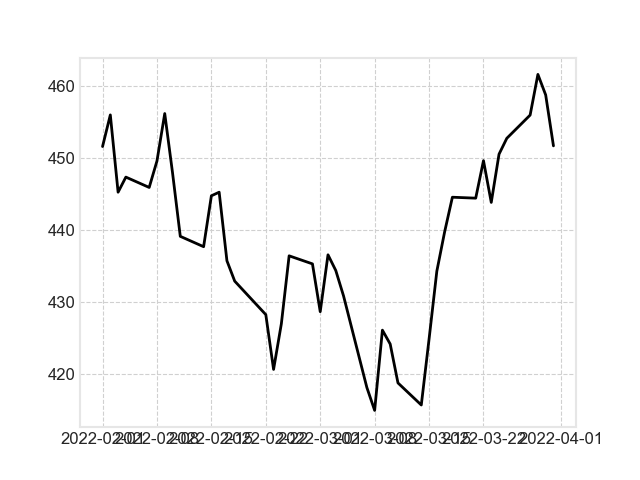

In [17]:
#Graph for the Fibonacci Levels
fig, ax = plt.subplots()
ax.plot(df.Close, color='black')

## Adding Fib Levels

In [18]:
# Define minimum and maximum price points
price_min = df.Close.min()
price_max = df.Close.max()

In [19]:
# Fibonacci Levels using the high and the low of the time period in question
diff = price_max - price_min
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.500 * diff
level4 = price_max - 0.618 * diff
level5 = price_max - 0.786 * diff

No handles with labels found to put in legend.


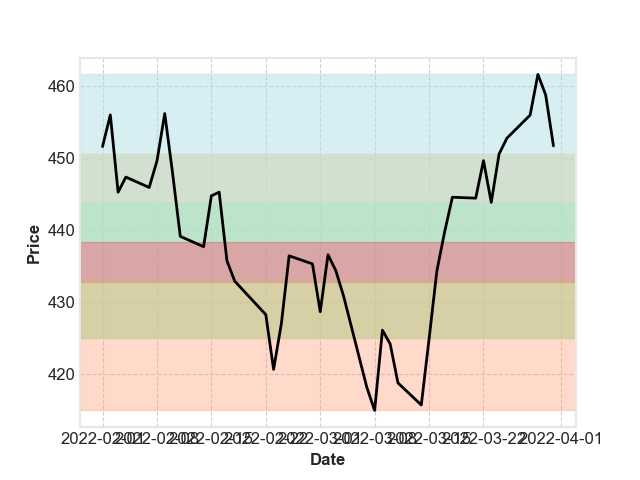

In [20]:
#This adds the Fibonacci Levels to the graph above:
#Level 1 at 23.6%
#Level 2 at 38.2%
#Level 3 at 50%
#Level 4 at 61.8%
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(level4, level3, alpha=0.5, color='red')
ax.axhspan(level5, level4, alpha=0.5, color='orange')
ax.axhspan(price_max, level5, alpha=0.5, color='powderblue')

plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

## Tradingview Rec

In [21]:
symbol_tv = TA_Handler(
    symbol="TSLA",
    screener="america",
    exchange="NASDAQ",
    interval=Interval.INTERVAL_1_HOUR,
    # proxies={'http': 'http://example.com:8080'} # Uncomment to enable proxy (replace the URL).
)
print(symbol_tv.get_analysis().summary)

{'RECOMMENDATION': 'SELL', 'BUY': 6, 'SELL': 14, 'NEUTRAL': 6}


# Rules for Entering a Trade. 
## Points must add up to at least 9/12
1. Identify strong trend and direction using ADX (+3pt)
2. Price is at the low/high of Bollinger Bands and Keltner Channel (+3pt)
3. Price is near a fibonnacci level (+3pt)
4. Volume is near the highs of the day (+2pt)
5. Use tradingview reccomendation before making final decision. (+1pt)

## News API


In [22]:
value = input("Enter Stock Symbol:")

Enter Stock Symbol: spy


In [69]:
# Read your api key environment variable
from newsapi.newsapi_client import NewsApiClient
load_dotenv()
api_key = os.getenv('NEWSAPI_KEY')

In [70]:
api_key

'da1e9a6806334ef58648fbb684ba57df'

In [71]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [72]:
# Fetch the Stock news articles
stock_headlines = newsapi.get_everything(q=value,
                                        language="en",
                                        page_size=100,
                                        sort_by='relevancy')
#save json
with open('stock.json', 'w') as json_file:
   json.dump(stock_headlines, json_file)

## SKLearn


In [41]:
# Import sklearn required libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
%matplotlib inline

In [42]:
df_stock["pct_change"] = df_stock['Close'].pct_change()*100

In [45]:
# Set x variable list of features
x_var_list = ['Open', 'High', 'Low', 'Close', 'Moving average', 'upper_BB', 'lower_BB', 'm_avg_08', 'pct_change', 'upper_KC', 'lower_KC']

# Filter by x-variable list
df_stock[x_var_list]

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2021-05-19,401.634701,405.711033,400.065327,405.523499,405.523499,NaN,NaN,405.523499,NaN,416.814912,394.232085
2021-05-20,406.451298,411.218580,406.323012,409.886108,407.813869,NaN,NaN,407.977467,1.075797,419.157008,396.470730
2021-05-21,411.455431,412.768173,409.066881,409.550507,408.451552,NaN,NaN,408.637654,-0.081877,418.354186,398.548917
2021-05-24,411.919338,414.860643,411.662706,413.725586,409.974084,NaN,NaN,410.420877,1.019430,420.082531,399.865637
2021-05-25,414.870498,415.245567,412.195705,412.807648,410.659499,NaN,NaN,411.162300,-0.221871,419.806590,401.512407
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,389.369995,395.799988,385.149994,392.339996,416.382000,449.213367,383.550634,403.594234,-0.104393,438.426926,394.337075
2022-05-13,396.709991,403.179993,395.609985,401.720001,414.985619,447.649855,382.321384,403.177738,2.390785,436.997369,392.973869
2022-05-16,399.980011,403.970001,397.600006,400.089996,413.566989,445.777755,381.356222,402.491573,-0.405756,434.735851,392.398126


In [46]:
# Drop NAs
df_stock = df_stock.dropna(subset=x_var_list)
df_stock = df_stock.dropna(subset=["pct_change"])

# Replace positive/negative infinity values
df_stock = df_stock.replace([np.inf, -np.inf], np.nan)



In [47]:
# Construct the dependent variable where if hourly return is greater than 0, then 1, else, 0.
df_stock["Positive Return"] = np.where(df_stock["pct_change"] > 0, 1.0, 0.0)

# Display sample data
df_stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Moving average,upper_BB,lower_BB,bol_percent_b,tr0,tr1,tr2,tr,upper_KC,lower_KC,m_avg_08,m_avg_21,m_avg_34,m_avg_55,m_avg_89,atr,plus_di,minus_di,adx,ADX_trend,pct_change,Positive Return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-16,419.114638,419.351511,414.465823,416.627350,80386100,0.000,0,416.290365,423.316811,409.263919,52.397975,4.885688,0.384867,4.500822,4.885688,422.056361,410.524369,417.502392,416.229809,415.719794,415.367357,415.137249,2.843418,25.686927,19.641042,64.337837,20,-0.558349,0.0
2021-06-17,416.193105,417.525547,413.873623,416.489197,90949700,0.000,0,416.311939,421.863700,410.760177,51.596415,3.651924,0.898197,2.753727,3.651924,422.239583,410.384294,417.276083,416.257074,415.781774,415.442377,415.217108,2.956837,22.418653,18.993057,59.481098,20,-0.033160,0.0
2021-06-18,413.019410,413.752179,410.652751,410.870605,118676300,1.376,0,415.729274,421.093281,410.365266,4.710466,3.099427,2.737018,5.836445,5.836445,422.252361,409.206186,415.846969,415.698815,415.395200,415.145892,414.969485,3.358006,17.953444,23.892618,54.787347,20,-1.349037,0.0
2021-06-21,412.732220,416.950654,411.870716,416.752594,72822000,0.000,0,415.837570,420.481772,411.193368,59.851256,5.079938,6.080049,1.000110,6.080049,422.937537,408.737602,416.048843,415.806657,415.499789,415.247138,415.067659,3.734970,22.314324,19.573100,51.063221,20,1.431591,1.0
2021-06-22,416.742698,419.861950,415.980194,418.980621,57700300,0.000,0,416.166707,420.931896,411.401517,79.525737,3.881756,3.109356,0.772400,3.881756,423.333813,408.999600,416.701917,416.127804,415.762756,415.476152,415.276247,3.755193,27.025096,17.768029,47.198398,20,0.534616,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,389.369995,395.799988,385.149994,392.339996,125090800,0.000,0,416.382000,449.213367,383.550634,13.385618,10.649994,3.049988,7.600006,10.649994,438.426926,394.337075,403.594234,417.116201,424.003030,430.154147,435.482839,11.633984,12.112027,29.415998,22.842885,20,-0.104393,0.0
2022-05-13,396.709991,403.179993,395.609985,401.720001,104029300,0.000,0,414.985619,447.649855,382.321384,29.693971,7.570007,10.839996,3.269989,10.839996,436.997369,392.973869,403.177738,415.716546,422.729714,429.138528,434.729819,11.528119,15.922838,27.565693,24.111549,20,2.390785,1.0
2022-05-16,399.980011,403.970001,397.600006,400.089996,78622400,0.000,0,413.566989,445.777755,381.356222,29.079989,6.369995,2.250000,4.119995,6.369995,434.735851,392.398126,402.491573,414.295951,421.436015,428.100967,433.957303,10.840369,16.244081,27.220657,24.293852,20,-0.405756,0.0


In [52]:
# Construct training start and end dates
training_start = df_stock.index.min().strftime(format= "%Y-%m-%d")
training_end = "2021-07-19"

# Construct testing start and end dates
testing_start =  "2022-04-18"
testing_end = df_stock.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2021-06-16
Training End: 2021-07-19
Testing Start: 2022-04-18
Testing End: 2022-05-18


In [53]:
# Construct the X_train and y_train datasets
X_train = df_stock[x_var_list][training_start:training_end]
y_train = df_stock["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2021-07-13,431.982517,433.566908,431.061601,431.338867,425.222054,437.445235,412.998872,429.229674,-0.340893,431.837129,418.606978
2021-07-14,433.131165,433.646110,430.665476,431.982483,425.879162,438.487887,413.270437,429.841443,0.149213,432.433319,419.325004
2021-07-15,430.566462,431.279436,428.496863,430.507050,426.328108,438.742328,413.913889,429.989362,-0.341549,432.921039,419.735178
2021-07-16,431.754777,431.804277,426.714456,427.130341,426.405795,438.227834,414.583755,429.354003,-0.784356,433.331474,419.480115
2021-07-19,422.030604,427.199661,417.851788,420.822510,425.865987,435.825568,415.906406,427.458066,-1.476793,433.881574,417.850400


Date
2021-07-13    0.0
2021-07-14    1.0
2021-07-15    0.0
2021-07-16    0.0
2021-07-19    0.0
Name: Positive Return, dtype: float64

In [55]:
# Construct the X test and y test datasets
X_test = df_stock[x_var_list][testing_start:testing_end]
y_test = df_stock["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

,Open,High,Low,Close,Moving average,upper_BB,lower_BB,m_avg_08,pct_change,upper_KC,lower_KC
Date,,,,,,,,,,,
2022-05-12,389.369995,395.799988,385.149994,392.339996,416.382000,449.213367,383.550634,403.594234,-0.104393,438.426926,394.337075
2022-05-13,396.709991,403.179993,395.609985,401.720001,414.985619,447.649855,382.321384,403.177738,2.390785,436.997369,392.973869
2022-05-16,399.980011,403.970001,397.600006,400.089996,413.566989,445.777755,381.356222,402.491573,-0.405756,434.735851,392.398126
2022-05-17,406.529999,408.570007,402.579987,408.320007,413.067276,442.425470,383.709082,403.786781,2.057040,433.853517,392.281035
2022-05-18,403.500000,403.799988,390.549988,391.859985,411.047534,438.362488,383.732581,401.136382,-4.031157,433.175029,388.920039


Date
2022-05-12    0.0
2022-05-13    1.0
2022-05-16    0.0
2022-05-17    1.0
2022-05-18    0.0
Name: Positive Return, dtype: float64

In [56]:
# Fit a SKLearn random forest using just the training set (X_train, Y_train):
#from imblearn.ensemble import EasyEnsembleClassifier
#model = EasyEnsembleClassifier(n_estimators = 100, random_state = 1)
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results.tail()

,Positive Return,Predicted Value
Date,,
2022-05-12,0.0,0.0
2022-05-13,1.0,1.0
2022-05-16,0.0,0.0
2022-05-17,1.0,1.0
2022-05-18,0.0,0.0


In [58]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sample data
results.tail(10)

,Positive Return,Predicted Value
Date,,
2022-05-05,0.0,0.0
2022-05-06,0.0,0.0
2022-05-09,0.0,0.0
2022-05-10,1.0,1.0
2022-05-11,0.0,0.0
2022-05-12,0.0,0.0
2022-05-13,1.0,1.0
2022-05-16,0.0,0.0
2022-05-17,1.0,1.0


<AxesSubplot:xlabel='Date'>

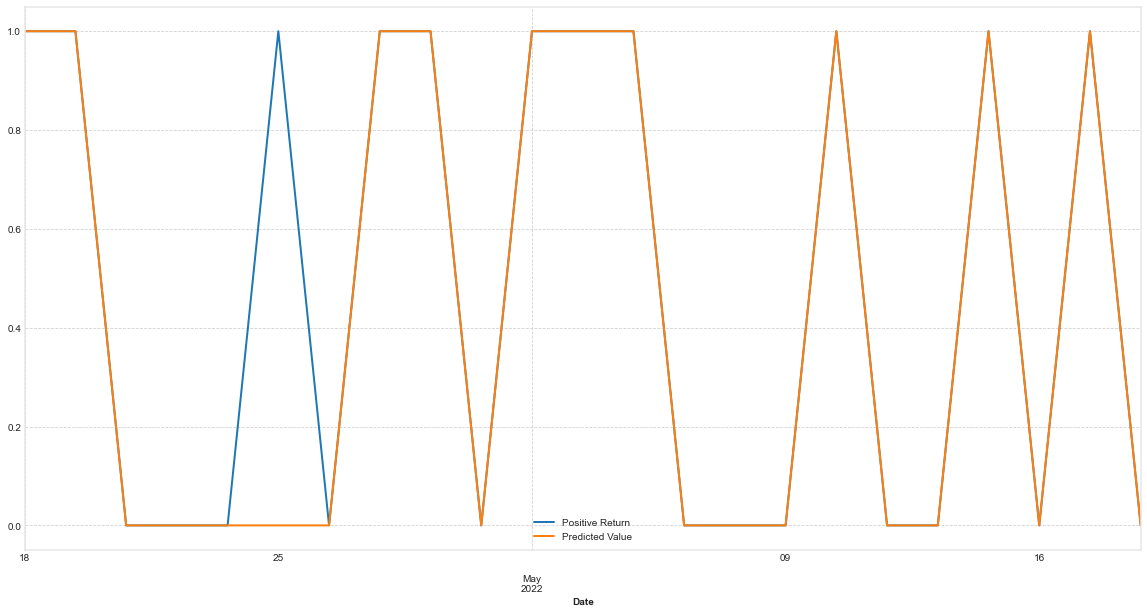

In [59]:
# Plot predicted results vs. actual results
results[["Positive Return", "Predicted Value"]].plot(figsize=(20,10))